# Clone repository

1. Clone repository from Gitlab. Repository URL - {GIT_PATH}
2. Repository is cloned into {LOCAL_PATH} directory
3. Branch {BRANCH} is used

In [1]:
GIT_PATH = "https://github.com/lacteolus/word2vec.git"
LOCAL_PATH = "word2vec"
BRANCH = "main"

In [2]:
import os

In [3]:
cmd_string = f'git clone {GIT_PATH} {LOCAL_PATH}'
os.system(cmd_string)

0

In [4]:
%cd {LOCAL_PATH}

/content/word2vec


In [5]:
!git checkout {BRANCH}

Already on 'main'
Your branch is up to date with 'origin/main'.


In [6]:
! git pull

Already up to date.


# Evaluations

## Common preparation

In [9]:
import torch

In [10]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
words = [
    "king", 
    "queen",
    "prince",
    "princess",
    "man", 
    "woman", 
    "mother", 
    "father", 
    "sister", 
    "brother",
    "mathematics", 
    "physics", 
    "chemistry",
    "science",
    "son",
    "daughter",
    "october",
    "september",
    "february",
    "germany",
    "russia",
    "berlin",
    "moscow",
    "france",
    "paris",
    "one",
    "two",
    "three"
]

## Gensim model

In [12]:
from src.gensim_word2vec import GensimWord2Vec

In [13]:
gensim_model = GensimWord2Vec()

[============================================------] 88.4% 28.0/31.6MB downloaded

In [14]:
gensim_model.show_info()

Epochs: 5
Window size: 5
Corpus size: 1701
Vector size: 100
Vocabulary size: 71290


In [15]:
gensim_model.most_similar("king")

[('prince', 0.7583558559417725),
 ('queen', 0.7222619652748108),
 ('emperor', 0.7080965638160706),
 ('kings', 0.6899330019950867),
 ('throne', 0.6755132079124451),
 ('pharaoh', 0.6747444272041321),
 ('regent', 0.6646072864532471),
 ('antiochus', 0.6527697443962097),
 ('sultan', 0.651141881942749),
 ('vii', 0.6507961750030518)]

In [16]:
gensim_model.most_similar("city")

[('town', 0.7851694226264954),
 ('downtown', 0.708640992641449),
 ('suburbs', 0.6805513501167297),
 ('cities', 0.6755889654159546),
 ('fredericton', 0.659480094909668),
 ('area', 0.6550063490867615),
 ('borough', 0.650227427482605),
 ('district', 0.6428962349891663),
 ('towns', 0.6316224336624146),
 ('neighborhood', 0.6234588623046875)]

In [17]:
gensim_model.analogy('king', 'man', 'queen')

'woman'

In [18]:
gensim_model.analogy('drive', 'car', 'ride')

'driver'

In [19]:
gensim_model.analogy('day', 'week', 'year')

'month'

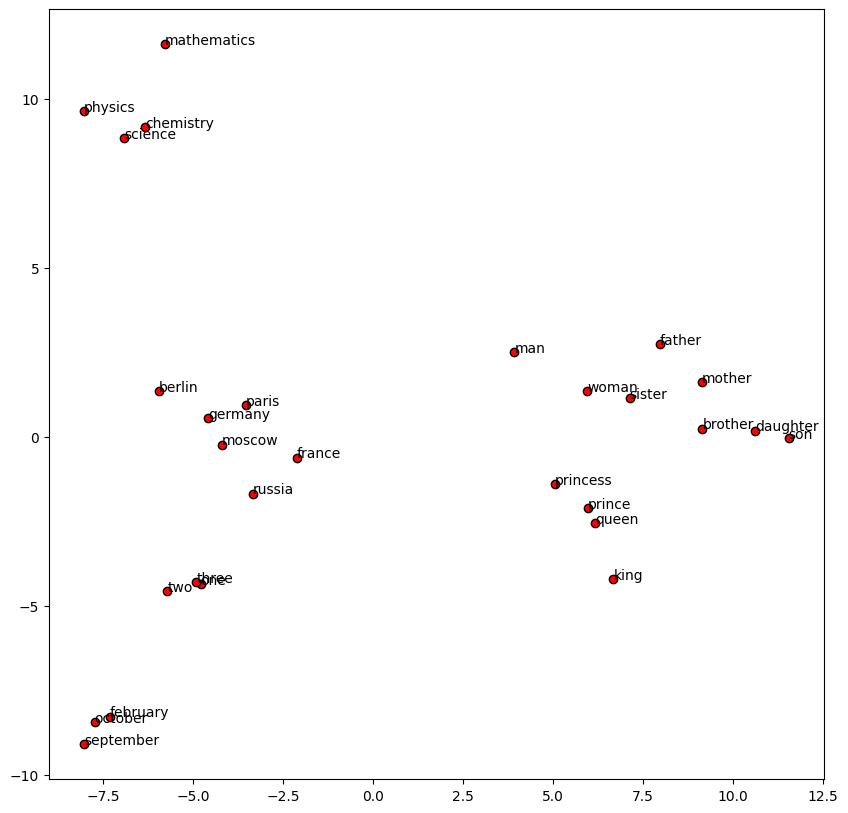

In [20]:
gensim_model.display_pca_scatterplot(words=words)

## Custom models

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance
from src.custom_word2vec import CBOWModel, SkipGramModel
from src.vocab import Vocab

In [22]:
CBOW_MODEL_STATE_PATH = "./results/cbow/model_state.pth"
CBOW_VOCAB_PATH = "./results/cbow/vocab.json"

SKIPGRAM_MODEL_STATE_PATH = "./results/skipgram/model_state.pth"
SKIPGRAM_VOCAB_PATH = "./results/skipgram/vocab.json"

In [23]:
def display_pca_scatterplot(model, words: list, vocab) -> None:
    """
    Display scatterplot with words distribution
    :param model: Model to be used
    :param words: List of words to be displayed on the scatterplot
    :param vocab: Vocabulary
    :return: None
    """
    word_ids = [vocab.lookup_index(w) for w in words]
    word_vectors = np.array([model.embeddings.weight[idx].detach().numpy() for idx in word_ids])

    two_dim = PCA().fit_transform(word_vectors)[:, :2]

    plt.figure(figsize=(10, 10))
    plt.scatter(two_dim[:, 0], two_dim[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, two_dim):
        plt.annotate(text=word, xy=(x, y))

In [24]:
def get_distance_matrix(wordvecs, metric='cosine'):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, vocab, dist_matrix, k=10):
    idx = vocab.lookup_index(word)
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, vocab.lookup_token(i), dists[i]) for i in ind]
    return out

def most_similar(word, vocab, dmat):
  print([t[1] for t in get_k_similar_words(word, vocab, dmat)])

### CBOW Model

In [25]:
# Create model and load its state
cbow_model = CBOWModel(vocab_size=5000)
cbow_model.load_state_dict(torch.load(
    f=CBOW_MODEL_STATE_PATH,
    map_location=torch.device('cpu')
  ))

<All keys matched successfully>

In [26]:
# Load vocabulary
vocab = Vocab.from_file(CBOW_VOCAB_PATH)

In [27]:
# Word vectors from the model
wordvecs = cbow_model.linear.weight.cpu().detach().numpy()

# Distance matrix
dmat = get_distance_matrix(wordvecs, 'cosine')

In [28]:
most_similar("king", vocab, dmat)

['prince', 'iii', 'throne', 'henry', 'duke', 'son', 'vii', 'alexander', 'edward', 'viii']


In [29]:
most_similar("city", vocab, dmat)

['town', 'capital', 'centre', 'county', 'village', 'london', 'building', 'area', 'buildings', 'district']


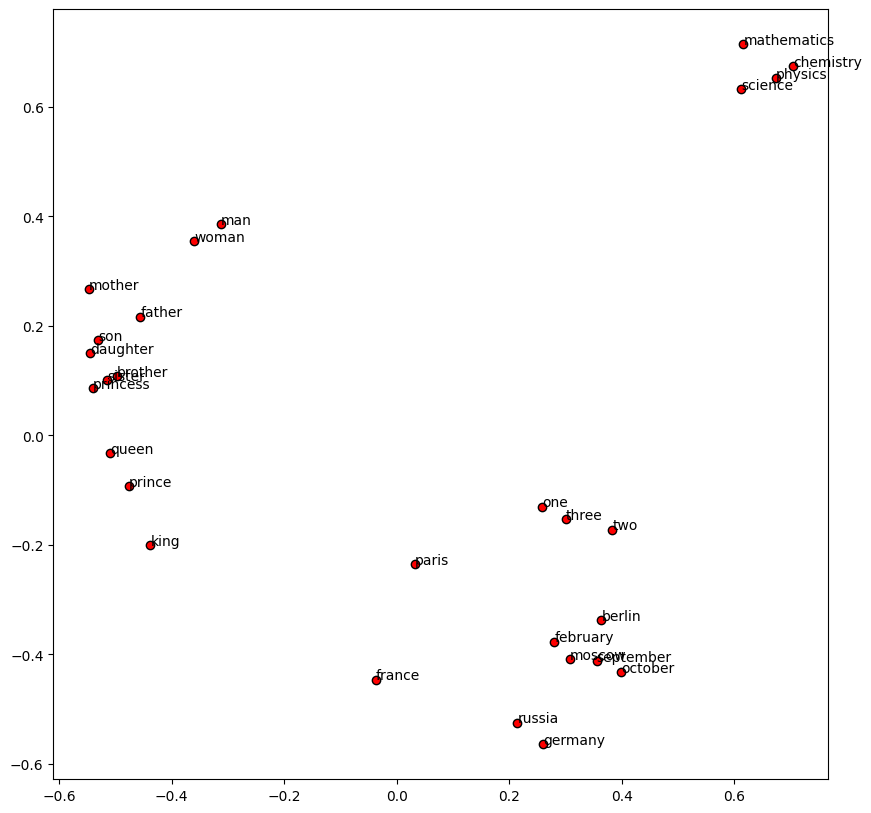

In [30]:
display_pca_scatterplot(cbow_model, words, vocab)

### SkipGram Model

In [31]:
DEVICE

device(type='cpu')

In [32]:
# Create model and load its state
skipgram_model = SkipGramModel(vocab_size=5000)
skipgram_model.load_state_dict(torch.load(
    f=SKIPGRAM_MODEL_STATE_PATH,
    map_location=torch.device('cpu')
  ))

<All keys matched successfully>

In [33]:
# Load vocabulary
vocab = Vocab.from_file(SKIPGRAM_VOCAB_PATH)

In [34]:
# Word vectors from the model
wordvecs = skipgram_model.linear.weight.cpu().detach().numpy()

# Distance matrix
dmat = get_distance_matrix(wordvecs, 'cosine')

In [35]:
most_similar("king", vocab, dmat)

['iii', 'henry', 'son', 'prince', 'england', 'duke', 'charles', 'throne', 'emperor', 'kings']


In [36]:
most_similar("city", vocab, dmat)

['town', 'area', 'capital', 'cities', 'county', 'london', 'york', 'new', 'located', 'building']


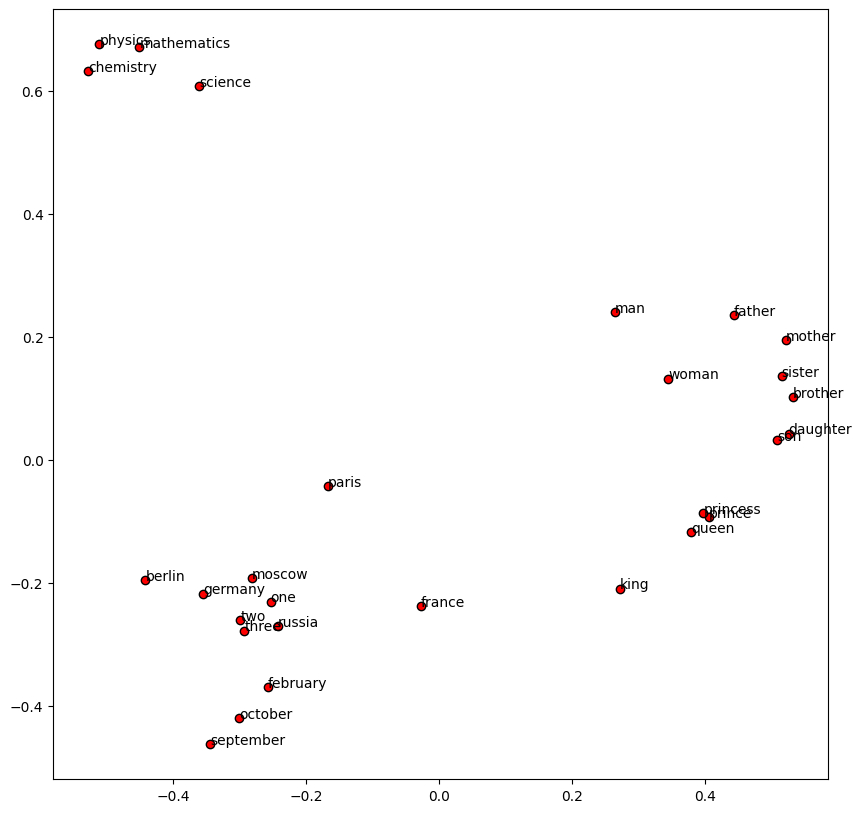

In [37]:
display_pca_scatterplot(skipgram_model, words, vocab)